### Installs / Imports

In [ ]:
# Run this command to install sklearn:
# Instalar sklearn:
!pip install sklearn

# Run this command to install seaborn:
# Instalar seaborn:
!pip install seaborn

# Run this command to install pyspark:
# Instalar pyspark:
#!pip install pyspark[sql]
!pip install pyspark[pandas_on_spark]

In [2]:
# Necessary imports
# Imports necessarios
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark.sql
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

### Data Loading - Cleaning - Exploration

In [3]:
# Load the data from sklearn dataset
# Carregar a data inicial do sklearn dataset
boston_initial_data = datasets.load_boston()

# Print the description of the data
# Print a descricao da data
print(boston_initial_data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [4]:
# Print the feature names (possible columns in the future)
# Print as feature names (possivelmente serao colunas depois)
print(boston_initial_data.feature_names)
# We can see from the print statement that the 'MEDV' col is missing
# Podemos ver que a coluna 'MEDV' nao esta nos feature names

# Print all keys of the dataset for further exploration
# Print todas as keys do dataset para explorar a data
print(boston_initial_data.keys())

# !!! The 'target' key corresponds to the missing MEDV col !!!
# !!! A key 'target' corresponde a coluna MEDV !!!

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])


In [5]:
# Create a pandas df with the dataset
# Criar um pandas df com o dataset original
boston_df = pd.DataFrame(boston_initial_data.data, columns=boston_initial_data.feature_names)

# Add the target col as MEDV
# Adicionar a coluna target como MEDV
boston_df['MEDV'] = boston_initial_data.target

In [6]:
# Check the first 5 rows from the df
# Verificar as primeiras filas do df
boston_df.head()

# !!! DATA  OK !!!

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
# Second check - null values
# Segunda verificacao - valores nulos
boston_df.isnull().sum()

# !!! DATA OK !!!

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Now that we've checked that the data OK, we can explore it.

Agora que verificamos que a data esta OK, podemos comecar a explorar o dataset.

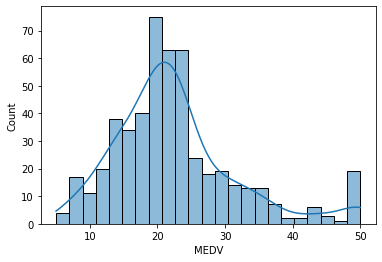

In [8]:
# Using seaborn histplot (kde=true gives us the curve)
# Usando seaborn histplot (kde=true inclui a curva no grafico)
sns.histplot(boston_df['MEDV'], kde=True)

# We can see that there is a normal distribution with outliers
# Podemos ver que existe uma distribuicao normal com valores atipicos

Since we have so many possible variables for our linear regression model, we should create a correlation matrix to check which variable has the highest positive correlation and lowest negative correlation with out target (MEDV). We will create three models, two will use the highest and lowest correlation variables, and the other model will use the VectorAssembler transformer from PySpark to combine all variables into one, and use this single merged variable.

Como temos tantas variaveis possiveis para o modelo de regressao linear, 
podemos criar uma matriz de correlacao para verificar as variaveis e encontrar
a variavel com a maior correlacao positiva e menor correlacao negativa em relacao ao target (MEDV). Vamos criar tres modelos diferentes; dois serao com as variaveis com maior e menor correlacao, e o terceiro modelo usara a funcao VectorAssembler do PySpark para combinar todas as variaveis em uma so, e usar essa variavel combinada no modelo.

In [9]:
# Create a correlation matrix
# Matriz de correlacao
correlation = boston_df.corr()

# Print the correlations between all vars and MEDV (sorted)
# Print as correlacoes entre as variaveis e MEDV (em ordem)
print(correlation['MEDV'].sort_values(ascending=False))

# !!! HIGHEST - RM /// LOWEST - LSTAT !!!
# !!! MAIOR - RM /// MENOR - LSTAT !!!

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


### Functions / Funcoes

In [10]:
def split_datasets(df, train, test):
  training_data, test_data = df.randomSplit([train,test])
  return training_data, test_data

In [11]:
def vectorAssemble(df, in_cols, out, target):
  # Using the VectorAssembler function to merge all columns together
  # Usando a funcao VectorAssembler para combinar todas as variaveis
  assembler = VectorAssembler(inputCols=in_cols, outputCol=out)

  # Combining the new Features col to our df, then removing unecessary cols
  # Combinando a nova coluna Features com a nossa df, e removendo as outras cols
  vector_df = assembler.transform(df).select([out,target])
  return vector_df

In [12]:
def createLinearRegModel(df, features, label):
  # Now we use the LinearRegression function (using MSE as loss function)
  # Agora usamos LinearRegression, usando MSE como a loss function
  model = LinearRegression(featuresCol = features, labelCol = label)

  # Fit the training data into the lin regression model
  # Fazemos o ajuste da data no modelo de regressao linear
  model = model.fit(df)

  return model

### SPARKSESSION - DATAFRAME

In [13]:
# Now we will start using PySpark. We need to create a SparkSession
# Agora vamos comecar a usar pyspark. Precisamos criar uma SparkSession
spark = pyspark.sql.SparkSession \
    .builder.master('local[16]') \
    .appName("Linear Regression Model YHub") \
    .getOrCreate()

# SparkSession syntax: 
# master(local[x]) --> This is the master node, running locally with 16 cores (partitions)
# appname () --> Name of the sparksession app

# Create a spark df for the boston df
# Criar uma spark df com a data do boston df
boston_spark_df = spark.createDataFrame(boston_df)

### VectorAssemble Model

In [14]:
# Using VectorAssemble to combine all variables
# Usando VectorAssemble para combinar todas as variaveis
vector_boston_spark_df = vectorAssemble(boston_spark_df, \
                                        ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'], \
                                        'FEATURES', 'MEDV')

# Split df into two; training and test data (75/25)
# Separar a df em dois; data de treino e teste (75/25)
vector_training_data, vector_test_data = split_datasets(vector_boston_spark_df,0.75,0.25)

vector_model = createLinearRegModel(vector_training_data, 'FEATURES', 'MEDV')

In [15]:
# Create a LinearRegressionSummary object using the evaluate method
# Criar um objeto LinearRegressionSummary usando o metodo "evaluate"
vector_test_predictions = vector_model.evaluate(vector_test_data)
vector_test_predictions.predictions.show(10)

+--------------------+----+------------------+
|            FEATURES|MEDV|        prediction|
+--------------------+----+------------------+
|[0.02729,0.0,7.07...|34.7| 30.30059239205407|
|[0.02985,0.0,2.18...|28.7|25.488495809080394|
|[0.17004,12.5,7.8...|18.9|19.430368806688282|
|[0.75026,0.0,8.14...|15.6|15.942025928130374|
|[0.84054,0.0,8.14...|13.9|13.830032671307073|
|[0.95577,0.0,8.14...|14.8|14.859216544792886|
|[0.01311,90.0,1.2...|35.4|31.152335505549768|
|[0.0536,21.0,5.64...|25.0|27.703446704395475|
|[0.06417,0.0,5.96...|18.9|24.143673165850274|
|[0.12269,0.0,6.91...|21.2|23.079412992714094|
+--------------------+----+------------------+
only showing top 10 rows



In [16]:
# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
vector_training_r2 = vector_model.summary.r2
print("Vector training r-squared: {}".format(vector_training_r2))

# Check the RMSE value of the model
# Verificando o valor do erro quadratico medio do modelo
vector_training_rmse = vector_model.summary.rootMeanSquaredError
print("Vector training RMSE:      {}".format(vector_training_rmse))

# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
vector_test_r2 = vector_test_predictions.r2
print("Vector test r-squared:     {}".format(vector_test_r2))

# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
vector_test_rmse = vector_test_predictions.rootMeanSquaredError
print("Vector test RMSE:          {}\n".format(vector_test_rmse))

vector_r2_difference = vector_test_r2 - vector_training_r2
vector_rmse_difference = vector_test_rmse - vector_training_rmse
print("Vector model r-squared difference: {}".format(vector_r2_difference))
print("Vector model RMSE difference:      {}".format(vector_rmse_difference))

Vector training r-squared: 0.7161393710179738
Vector training RMSE:      4.788335553907964
Vector test r-squared:     0.7821760851803056
Vector test RMSE:          4.525390386004352

Vector model r-squared difference: 0.06603671416233181
Vector model RMSE difference:      -0.2629451679036121


### RM Model

In [17]:
# Using the RM variable 
rm_boston_spark_df = boston_spark_df.select(['RM','MEDV'])

rm_boston_spark_df = vectorAssemble(boston_spark_df, ['RM'], 'vRM', 'MEDV')

# Split df into two; training and test data (75/25)
# Separar a df em dois; data de treino e teste (75/25)
rm_training_data, rm_test_data = split_datasets(rm_boston_spark_df,0.75,0.25)

rm_model = createLinearRegModel(rm_training_data, 'vRM', 'MEDV')

In [18]:
# Create a LinearRegressionSummary object using the evaluate method
# Criar um objeto LinearRegressionSummary usando o metodo "evaluate"
rm_test_predictions = rm_model.evaluate(rm_test_data)
rm_test_predictions.predictions.show(10)

+-------+----+------------------+
|    vRM|MEDV|        prediction|
+-------+----+------------------+
| [5.57]|13.6| 15.60693057808583|
|[5.834]|19.9|18.086076448640966|
|[5.949]|20.4|19.166007414981273|
|[5.965]|19.6|19.316258679863402|
|[6.377]|15.0|23.185228750578247|
|[6.495]|18.4|24.293331829083954|
|[6.575]|24.0|  25.0445881534946|
|[6.998]|33.4| 29.01685596881591|
|[5.399]|14.4| 14.00112018465807|
|[5.682]|19.3|16.658689432260744|
+-------+----+------------------+
only showing top 10 rows



In [19]:
# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
rm_training_r2 = rm_model.summary.r2
print("RM training r-squared: {}".format(rm_training_r2))

# Check the RMSE value of the model
# Verificando o valor do erro quadratico medio do modelo
rm_training_rmse = rm_model.summary.rootMeanSquaredError
print("RM training RMSE:      {}".format(rm_training_rmse))

# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
rm_test_r2 = rm_test_predictions.r2
print("RM test r-squared:     {}".format(rm_test_r2))

# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
rm_test_rmse = rm_test_predictions.rootMeanSquaredError
print("RM test RMSE:          {}\n".format(rm_test_rmse))

rm_r2_difference = rm_test_r2 - rm_training_r2
rm_rmse_difference = rm_test_rmse - rm_training_rmse
print("RM model r-squared difference: {}".format(rm_r2_difference))
print("RM model RMSE difference:      {}".format(rm_rmse_difference))

RM training r-squared: 0.504894401166686
RM training RMSE:      6.373196729842276
RM test r-squared:     0.41475222888721097
RM test RMSE:          7.3491407810698

RM model r-squared difference: -0.09014217227947507
RM model RMSE difference:      0.9759440512275246


### LSTAT MODEL

In [20]:
# Using the LSTAT variable
lstat_boston_spark_df = boston_spark_df.select(['LSTAT','MEDV'])

lstat_boston_spark_df = vectorAssemble(boston_spark_df, ['LSTAT'], 'vLSTAT', 'MEDV')

# Split df into two; training and test data (75/25)
# Separar a df em dois; data de treino e teste (75/25)
lstat_training_data, lstat_test_data = split_datasets(lstat_boston_spark_df,0.75,0.25)

lstat_model = createLinearRegModel(lstat_training_data, 'vLSTAT', 'MEDV')

In [21]:
# Create a LinearRegressionSummary object using the evaluate method
# Criar um objeto LinearRegressionSummary usando o metodo "evaluate"
lstat_test_predictions = lstat_model.evaluate(lstat_test_data)
lstat_test_predictions.predictions.show(10)

+-------+----+------------------+
| vLSTAT|MEDV|        prediction|
+-------+----+------------------+
| [2.94]|33.4|31.562220294425693|
| [5.33]|36.2|29.317264116332233|
|[11.28]|18.2|23.728356476308754|
|[11.98]|21.0| 23.07083793042364|
|[18.72]|15.2|16.739873645758394|
|[19.15]|27.1|16.335969396143252|
|[21.02]|13.6|14.579455566421586|
| [4.32]|30.8| 30.26596944682361|
| [8.77]|21.0|26.086030119411095|
| [9.43]|20.5|25.466084061862272|
+-------+----+------------------+
only showing top 10 rows



In [22]:
# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
lstat_training_r2 = lstat_model.summary.r2
print("LSTAT training r-squared: {}".format(lstat_training_r2))

# Check the RMSE value of the model
# Verificando o valor do erro quadratico medio do modelo
lstat_training_rmse = lstat_model.summary.rootMeanSquaredError
print("LSTAT training RMSE:      {}".format(lstat_training_rmse))

# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
lstat_test_r2 = lstat_test_predictions.r2
print("LSTAT test r-squared:     {}".format(lstat_test_r2))

# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
lstat_test_rmse = lstat_test_predictions.rootMeanSquaredError
print("LSTAT test RMSE:          {}\n".format(lstat_test_rmse))

lstat_r2_difference = lstat_test_r2 - lstat_training_r2
lstat_rmse_difference = lstat_test_rmse - lstat_training_rmse
print("LSTAT model r-squared difference: {}".format(lstat_r2_difference))
print("LSTAT model RMSE difference:      {}".format(lstat_rmse_difference))

LSTAT training r-squared: 0.5453152771316218
LSTAT training RMSE:      6.17909472086293
LSTAT test r-squared:     0.5387677766551118
LSTAT test RMSE:          6.276498860222374

LSTAT model r-squared difference: -0.006547500476509982
LSTAT model RMSE difference:      0.09740413935944403


### GRAPHS / GRAFICOS

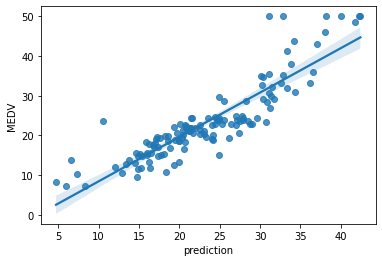

In [23]:
vector_pandas_df = vector_test_predictions.predictions.toPandas()
sns.regplot(x="prediction", y="MEDV", data=vector_pandas_df)

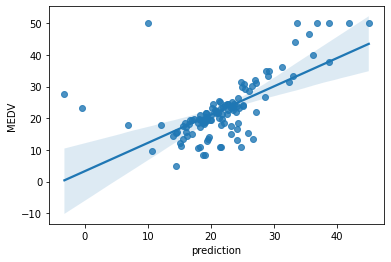

In [24]:
rm_pandas_df = rm_test_predictions.predictions.toPandas()
sns.regplot(x="prediction", y="MEDV", data=rm_pandas_df)

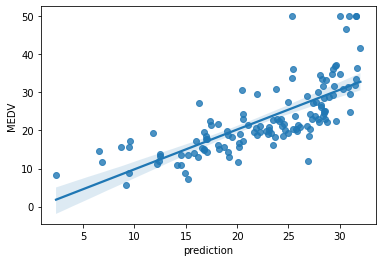

In [25]:
lstat_pandas_df = lstat_test_predictions.predictions.select(['prediction','MEDV']).toPandas()
sns.regplot(x="prediction", y="MEDV", data=lstat_pandas_df)

## Results
We had three different models; a vectorassemble model which combines all variables into one, a model which compares the RM variable (average rooms per dwelling) with the target, and finally a model using the LSTAT variable (% lower status of the population). 

From our results after running the training and test data in our models, we have that the best fit is the model using VectorAssemble, combining all variables into a single feature. It has the highest r-squared value and lowest RMSE value, and from the visual graph we can see the vector model has the best fit.


## Resultados
Comecamos com tres modelos diferentes; um modelo usando VectorAssemble que combinava todas as variaveis em uma so, um modelo que usa a variavel RM que tem a maior correlacao com o alvo, e um ultimo modelo que usa a variavel LSTAT que tem a menor correlacao com o alvo.

Pelos nossos resultados depois de rodar a data de treino e teste em todos os modelos, podemos ver que o modelo com melhor fit seria o modelo que usa VectorAssemble. Ele tem o maior valor de r ao quadrado, e o menor valor do erro quadratico medio. Alem disso, podemos ver com os graficos que esse modelo tem o melhor ajuste.